<a href="https://colab.research.google.com/github/esalbuquerquebr/projeto3_programacao_ia/blob/master/ifes_2020_1_ia_t3_p1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Projeto de Programação – Trabalho 3 – Learning
## Problema 1 - Aprendizado Não-Supervisionado (K-Means)
### IFES | 2020/1 | Inteligência Artificial
### Eduardo Soares Albuquerque
--------------------------------------

## Instruções para download do dataset e demais arquivos

### Instalando o Kaggle

In [ ]:
!pip install kaggle

### Orientações para autenticar no Kaggle usando kaggle.json

Navegue até as configurações de perfil do seu usuário: https://www.kaggle.com/me/account e clique em 'Create API Token' para fazer o download do kaggle.json para ser utilizado abaixo.

In [ ]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))
  
# Then move kaggle.json into the folder where the API expects to find it.
!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json
User uploaded file "kaggle.json" with length 74 bytes


### Download e unzip do dataset

In [ ]:
!kaggle datasets download -d olgabelitskaya/yale-face-database -p ./sample_data --unzip

 77% 9.00M/11.8M [00:00<00:00, 12.1MB/s]
100% 11.8M/11.8M [00:00<00:00, 16.1MB/s]


### Obter o arquivo XML do classificador

In [ ]:
!wget "https://raw.githubusercontent.com/opencv/opencv/master/data/haarcascades/haarcascade_frontalface_default.xml" -P ./sample_data/

--2020-09-14 11:48:29--  https://raw.githubusercontent.com/opencv/opencv/master/data/haarcascades/haarcascade_frontalface_default.xml
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 930127 (908K) [text/plain]
Saving to: ‘./sample_data/haarcascade_frontalface_default.xml’

haarcascade_frontal 100%[===================>] 908.33K  --.-KB/s    in 0.1s    

2020-09-14 11:48:30 (6.86 MB/s) - ‘./sample_data/haarcascade_frontalface_default.xml’ saved [930127/930127]



## Código-fonte para o Problema 1 - K-Means

### Imports das bibliotecas

In [ ]:
import os
import numpy as np
import cv2  
from google.colab.patches import cv2_imshow 
from skimage import io
from PIL import Image 
import matplotlib.pylab as plt
from sklearn.cluster import KMeans

### Definições de algumas constantes

In [ ]:
# Extensões válidas
VALID_SUFIXES = ['.happy', '.normal', '.sad', '.sleepy', '.surprised']

# Path para as imagens do dataset
YALEFACES_PATH = './sample_data/data'

# Classificador
CLASSIFIER_PATH = './sample_data/haarcascade_frontalface_default.xml'

# Número de clusters
CLUSTER_CENTROIDS = 5

# Quantidade de faces aleatórias
FACES_QTT = 5

### Função para obter validar extensões

> Apenas as definidas em VALID_SUFIXES

In [ ]:
def has_valid_sufix(filename):
  for SUFIX in VALID_SUFIXES:
    if filename.endswith(SUFIX):
      return True
  return False

### Definições das listas principais

In [ ]:
# Todos os arquivos
all_filenames = os.listdir(YALEFACES_PATH)

# Arquivos a serem considerados
valid_filesnames =  list(filter(lambda filename: has_valid_sufix(filename), all_filenames))

# Arquivos a serem considerados com path completo
valid_file_full_path = list(map(lambda filename: YALEFACES_PATH + '/' + filename, valid_filesnames))


### Definições das funções para leitura das imagens

In [ ]:
def convert_PIL2cv(pil_image):
    open_cv_image = np.array(pil_image.convert('RGB'))
    open_cv_image = open_cv_image[:, :, ::-1].copy() 
    return open_cv_image


def load_img(path):
    img = Image.open(path)
    img = convert_PIL2cv(img)
    return img

### Definção da função para pré-processamento de uma imagem

In [ ]:
def image_to_vect(file):
  
  face_cascade = cv2.CascadeClassifier(CLASSIFIER_PATH)

  # Carregar a imagem
  img = load_img(file)
  
  # Converter para escala cinza
  gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  
  # Detecção da face (retangulo)
  faces = face_cascade.detectMultiScale(gray, 1.1, 4)

  # Como o dataset só possui um rosto...
  (x, y, w, h) = faces[0]

  # Cálculos para as crop de 20% no topo, esquerda e direita
  ml = int(x * 0.2)
  mt = int((y + h) * 0.2)

  # Definição do retângulo
  #cv2.rectangle(gray, (x, y), (x+w, y+h), (255, 0, 0), 2)
  #cv2.rectangle(gray, (x+ml, y+mt), (x+w-ml, y+h), (155, 130, 0), 2)
  
  # Crop de 20% no topo, esquerda e direita
  crop = gray[y+mt:y+h, x+ml:x+w-ml]

  # Equalização de histograma
  equ = cv2.equalizeHist(crop)

  # Redimensionamento  
  resized = cv2.resize(equ, (50,50))

  # Transformação em vetor
  np_resized = np.array(resized)
  np_resized_reshape = np_resized.reshape(1,-1)[0]

  return (np_resized_reshape, resized)

### Definição da lista com os vetores das imagens pré-processadas

In [ ]:
# Lista de imagens processadas
processed_list = list(map(lambda file: image_to_vect(file), valid_file_full_path))

# Lista dos vetores processados
vector_list = list(map(lambda p: p[0], processed_list))

# Lista dos vetores processados
processed_img_list = list(map(lambda p: p[1], processed_list))

### Definição do cluster

In [ ]:
kmeans = KMeans(n_clusters=CLUSTER_CENTROIDS, algorithm='elkan', n_init=100, max_iter=1000).fit(vector_list)

### Organizando o resultado

In [ ]:
# Definições dos clusters
labels = kmeans.labels_
len_cluster = len(labels)

# Organizando o resultado
result = [[],[],[],[],[]]
for i in range(0, len_cluster - 1):
  file_image = processed_img_list[i]
  cluster_index = labels[i]
  result[cluster_index].append(file_image)

### Definição da função para apresentaçao de um cluster

In [ ]:
def group_cluster_faces(imgs):
  line_img = cv2.hconcat(imgs)
  return line_img

def print_all_cluster(cluster_imgs):
  all_cluster = cv2.vconcat(cluster_imgs)
  return all_cluster


### Apresentando os resultados
Optei por apresentar todas as imagens do cluster...

Cluster #1


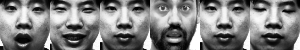

Cluster #2


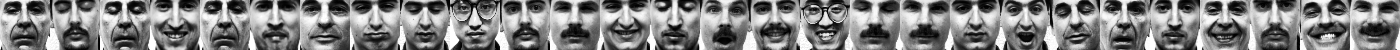

Cluster #3


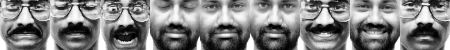

Cluster #4


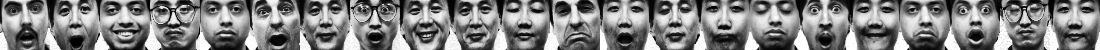

Cluster #5


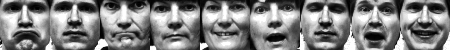

In [ ]:
cluster_imgs = map(lambda cf: group_cluster_faces(cf), result)
cluster_id = 1
for im in cluster_imgs:
  print(f'Cluster #{cluster_id}')
  cv2_imshow(im)  
  cluster_id +=1


## Comentários finais

### Funcionamento do K-Means 
*Explicação com minhas palavras (não coube em 1 parágrafo)*

K_Means é um algoritmo de clusterização, ou seja, um algoritmo utilizado para agrupar objetos de acordo com uma função que mede as distâncias (em geral euclidiana) entre eles. De forma geral, o algoritmo é utlizado para dividir n objetos em k grupos onde o objetivo é o de minimizar a média das distâncias entre os objetos de cada grupo em relação ao seu 'centro de gravidade' (ou centroide).

Em uma versão básica, inicialmente são criados k centroides aleatórios. Para cada ponto é calculada a distância de todos os centroides, atribuindo este ponto ao centroide com a menor distãncia. Uma vez determinado a qual grupo (a qual dos k centroides) cada ponto pertence, novos centroides são calculados pela média das distâncias daqueles pontos pentencetes a cada grupo. O algoritmo passa a repetir todos os passos a partir do calculo das distâncias entre todos os pontos para cada centroide até que seja atingida uma condição de parada, que pode ser o número de iterações, por exemplo.

### Descrição do critério observado para o agrupamento

O agrupamento resultante não foi estritamente por indivíduos nem pelas expressões faciais. Sabendo que a distância entre as imagens é dada pela  raíz quadrada da soma da diferença entre as cores dos pixels elevada ao quadrado, percebi que determinadas características de regiões das imagens determinaram o agrupamento. Por exemplo, nos agrupamentos gerados durante os testes, observei um grupo com tonalidades escuras na região da boca e tonalidades mais clara na região dos olhos, outro grupo formado exclusivamente por um indivíduo que possui um preenchimento maior e uniforme da área da foto, outro com tonalidades claras na região dos olhos e boca, etc
